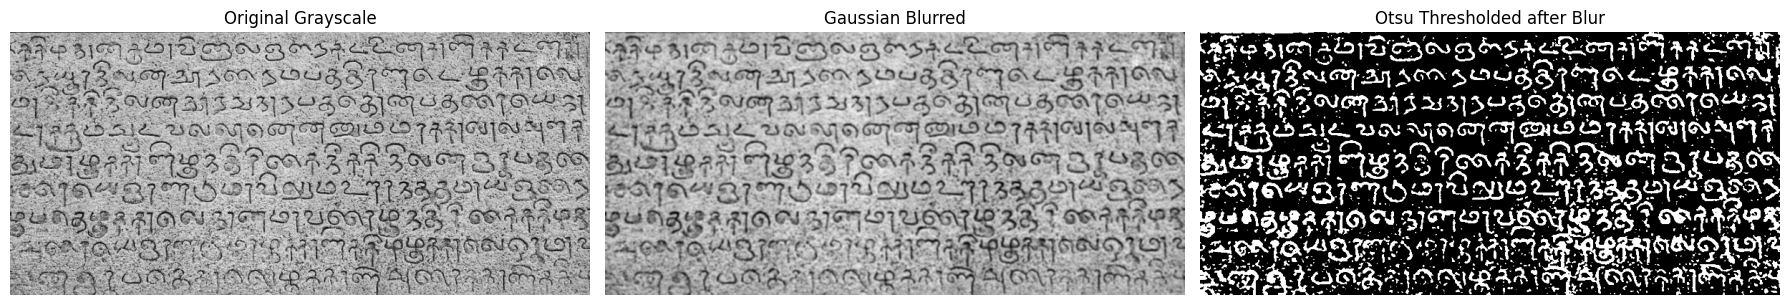

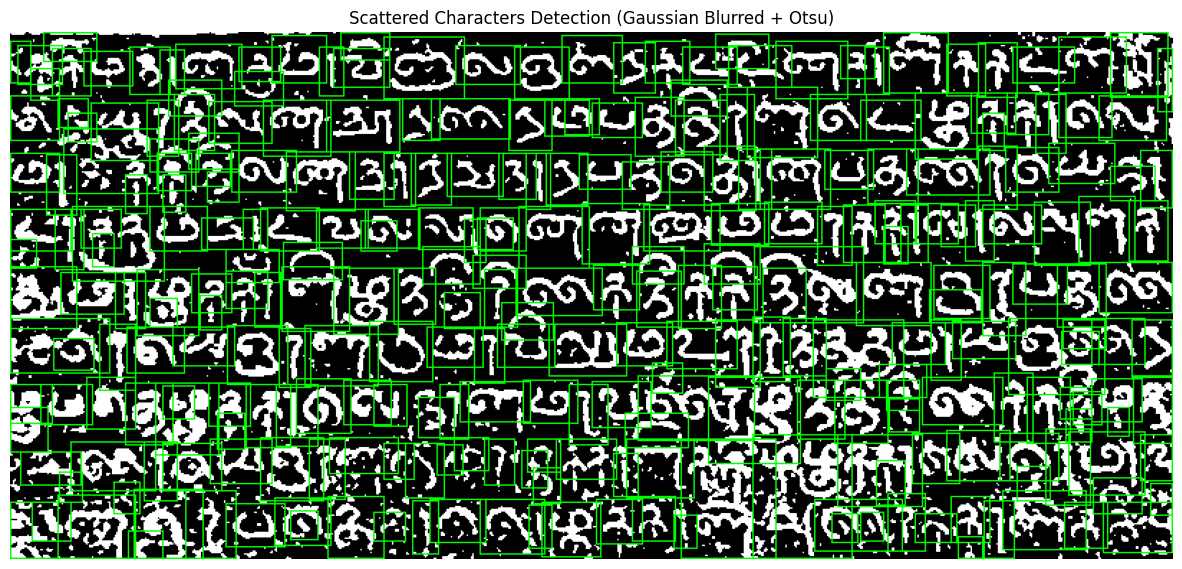

Total 296 characters saved in 'segmented_scattered_characters' folder.


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./photo3.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Invert and apply Otsu's thresholding
inverted_img = cv2.bitwise_not(blurred_img)
_, binary_img = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create output directory
output_dir = 'segmented_scattered_characters'
os.makedirs(output_dir, exist_ok=True)

# Visualize preprocessing
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Grayscale')
axs[1].imshow(blurred_img, cmap='gray')
axs[1].set_title('Gaussian Blurred')
axs[2].imshow(binary_img, cmap='gray')
axs[2].set_title('Otsu Thresholded after Blur')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Find contours (external characters)
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# For visualization: copy image
boxed_image = cv2.cvtColor(binary_img.copy(), cv2.COLOR_GRAY2BGR)

# Character extraction parameters
padding = 5
canvas_size = 64
char_count = 0

# Sort contours top-to-bottom, then left-to-right
bounding_boxes = [cv2.boundingRect(c) for c in contours]
contours = [c for _, c in sorted(zip(bounding_boxes, contours), key=lambda b: (b[0][1], b[0][0]))]

for idx, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)

    # Filter out small noise components
    if w < 5 or h < 10:
        continue  # Ignore tiny blobs, not letters

    # Add padding
    full_x_min = max(x - padding, 0)
    full_y_min = max(y - padding, 0)
    full_x_max = min(x + w + padding, binary_img.shape[1]-1)
    full_y_max = min(y + h + padding, binary_img.shape[0]-1)

    # Draw rectangle for visualization
    cv2.rectangle(boxed_image, (full_x_min, full_y_min), (full_x_max, full_y_max), (0, 255, 0), 1)

    # Crop and prepare the character
    cropped_char = binary_img[full_y_min:full_y_max+1, full_x_min:full_x_max+1]

    # Resize and center on canvas
    h_crop, w_crop = cropped_char.shape
    scale = min((canvas_size-10)/w_crop, (canvas_size-10)/h_crop)
    resized_char = cv2.resize(cropped_char, (int(w_crop*scale), int(h_crop*scale)), interpolation=cv2.INTER_AREA)

    canvas = np.ones((canvas_size, canvas_size), dtype=np.uint8) * 255  # white canvas
    x_offset = (canvas_size - resized_char.shape[1]) // 2
    y_offset = (canvas_size - resized_char.shape[0]) // 2
    canvas[y_offset:y_offset+resized_char.shape[0], x_offset:x_offset+resized_char.shape[1]] = 255 - resized_char

    # Save
    filename = f'char_{idx+1}.png'
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, canvas)
    char_count += 1

# Show all bounding boxes
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
plt.title('Scattered Characters Detection (Gaussian Blurred + Otsu)')
plt.axis('off')
plt.show()

print(f"Total {char_count} characters saved in '{output_dir}' folder.")


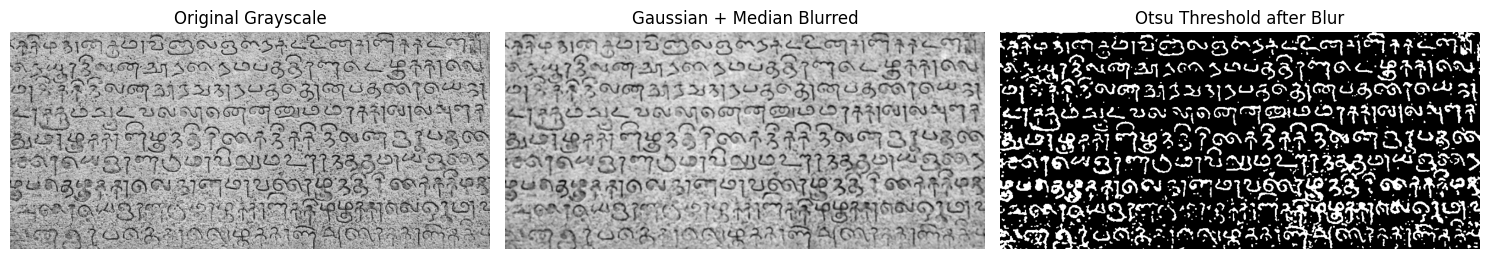

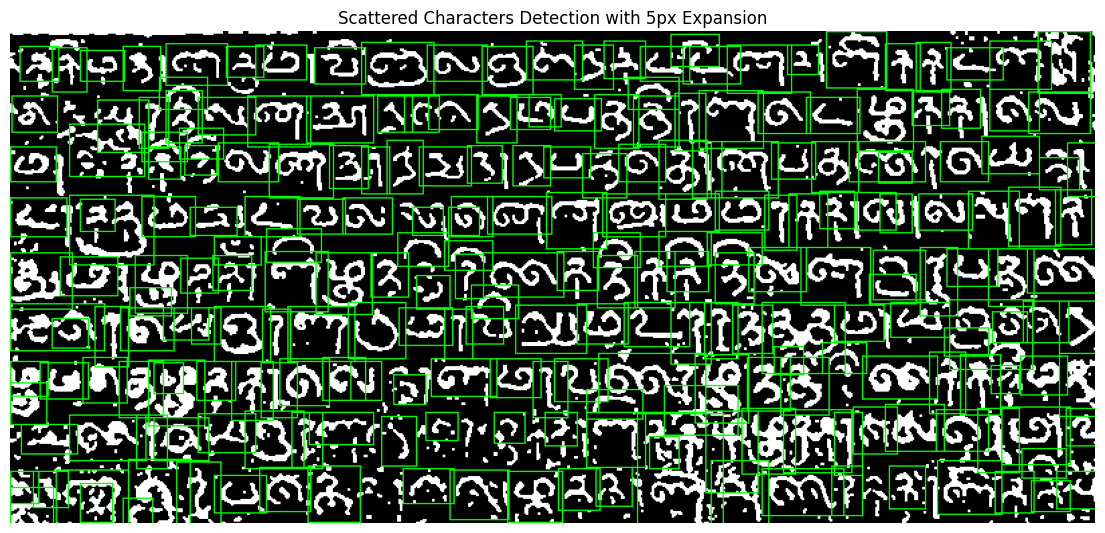

✅ Saved 247 character segments with 5px padding in folder: 'character_segments'


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load image and convert to grayscale
img_path = "./photo3.png"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Output directory
output_dir = "character_segments"
os.makedirs(output_dir, exist_ok=True)

# Preprocessing: blur + threshold
gaussian_blur = cv2.GaussianBlur(gray, (3, 3), 0)
median_blur = cv2.medianBlur(gaussian_blur, 3)
_, thresh = cv2.threshold(median_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((2, 2), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Display preprocessing stages
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[1].imshow(median_blur, cmap='gray')
axs[1].set_title("Gaussian + Median Blurred")
axs[2].imshow(cleaned, cmap='gray')
axs[2].set_title("Otsu Threshold after Blur")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Contour detection
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes = [cv2.boundingRect(c) for c in contours]
boxes = sorted(boxes, key=lambda b: (b[1], b[0]))  # top-to-bottom, left-to-right

# Image dimensions for boundary checking
height, width = cleaned.shape
boxed_img = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2BGR)
count = 0
padding = 5  # ← Reduced padding

for (x, y, w, h) in boxes:
    if w > 10 and h > 10:
        # Expand by 5 pixels, keep within image bounds
        x_pad = max(x - padding, 0)
        y_pad = max(y - padding, 0)
        w_pad = min(x + w + padding, width) - x_pad
        h_pad = min(y + h + padding, height) - y_pad

        cv2.rectangle(boxed_img, (x_pad, y_pad), (x_pad + w_pad, y_pad + h_pad), (0, 255, 0), 1)
        char_img = cleaned[y_pad:y_pad + h_pad, x_pad:x_pad + w_pad]
        cv2.imwrite(os.path.join(output_dir, f"char_{count+1}.png"), char_img)
        count += 1

# Display segmented image
plt.figure(figsize=(14, 10))
plt.title("Scattered Characters Detection with 5px Expansion")
plt.imshow(boxed_img)
plt.axis('off')
plt.show()

print(f"✅ Saved {count} character segments with 5px padding in folder: '{output_dir}'")


In [2]:
import cv2
import os

# Folder containing input images
input_folder = './test-images/'

# Loop through all files in the folder
for filename in os.listdir(input_folder):
    file_path = os.path.join(input_folder, filename)

    # Check if the file is an image based on its extension
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        # Read the image
        image = cv2.imread(file_path)
        if image is None:
            print(f"Skipping {filename} (couldn't read as image)")
            continue

        # Invert the image
        inverted_image = cv2.bitwise_not(image)

        # Save with a new name to avoid overwriting originals
        save_path = os.path.join(input_folder, f"inverted_{filename}")
        cv2.imwrite(save_path, inverted_image)
        print(f"Inverted and saved: {save_path}")



Inverted and saved: ./test-images/inverted_14_aug49.png
Inverted and saved: ./test-images/inverted_18_aug119.png
Inverted and saved: ./test-images/inverted_18_aug17.png
Inverted and saved: ./test-images/inverted_18_aug63.png
Inverted and saved: ./test-images/inverted_1_aug3.png
Inverted and saved: ./test-images/inverted_24_aug26.png
Inverted and saved: ./test-images/inverted_24_aug52.png
Inverted and saved: ./test-images/inverted_39_aug1.png
Inverted and saved: ./test-images/inverted_39_aug51.png
Inverted and saved: ./test-images/inverted_39_aug70.png
Inverted and saved: ./test-images/inverted_img1.jpg
Inverted and saved: ./test-images/inverted_Screenshot 2025-03-17 152736_aug87.png
Inverted and saved: ./test-images/inverted_Screenshot 2025-03-17 152736_aug89.png
Inverted and saved: ./test-images/inverted_Screenshot 2025-03-17 152749_aug42.png
